# Airbnb-Price-Predictions-Florida-Edition

## Summary

The Feature Engineering notebook focuses on enhancing the dataset by creating new features and exploring their relationships with the target variable (price) in the context of Airbnb listings in Florida.
Finally, the notebook concludes with feature scaling using StandardScaler for numeric features and one-hot encoding for categorical features. The scaled and encoded features are combined into a single dataframe, which is saved as a CSV file for further modeling.

---

# Table of Contents

1. [Imports](#Imports)
2. [Feature Engineering](#Feature-Engineering)
3. [Data Exploration](#Data-Exploration)

---



## Imports

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [ ]:
# Load the cleaned dataset
listings_cleaned = pd.read_csv('../data/cleaned_listings.csv')

## Feature Engineering

In [7]:
# Calculate the length of the description
listings_cleaned['description_length'] = listings_cleaned['description'].str.len()

**The length of the description can provide insights into how detailed or informative the listing is. Longer descriptions might indicate more thorough and attractive listings, which could potentially influence the price**.

In [8]:
# Convert the 'last_review' column to datetime format
listings_cleaned['last_review'] = pd.to_datetime(listings_cleaned['last_review'])

# Extract the month of the last review
listings_cleaned['last_review_month'] = listings_cleaned['last_review'].dt.month


**The month of the last review can capture seasonal patterns or trends in the demand for Airbnb listings. Prices might vary depending on the time of the year, such as during peak tourist seasons or special events**.

In [6]:
# Binary indicator for whether a listing has a host or not
listings_cleaned['has_host'] = listings_cleaned['host_name'].notnull().astype(int)

**Hosted listings might have additional amenities, personalized touches, or a higher level of service, which could affect the price**.

In [7]:
# Define a list of popular neighborhoods based on EDA notebook
popular_neighborhoods = ['Fort Lauderdale', 'Hollywood', 'Pompano Beach', 'Hallandale Beach', 'Deefield Beach', 'Wilton Manors', 'Oakland Park']

# Binary indicator for whether a listing is in a popular neighborhood
listings_cleaned['is_popular_neighborhood'] = listings_cleaned['neighbourhood'].isin(popular_neighborhoods).astype(int)

**Certain neighborhoods might be more desirable or sought after by travelers due to their location, amenities, or reputation. By identifying popular neighborhoods, we can capture any price differentials associated with those areas. We'll be using the the top five neighborhoods from the data cleaning notebook.**

In [8]:
# Extract specific amenities
amenities_to_extract = ['Smoke alarm', 'Wifi', 'Kitchen', 'Essentials', 'Hair dryer', 'Hangers', 'Dishes and silverware', 'Hot water', 'Iron', 'Refrigerator']
for amenity in amenities_to_extract:
    listings_cleaned[amenity] = listings_cleaned['amenities'].str.contains(amenity, case=False).astype(int)

# Feature for total number of amenities
listings_cleaned['total_amenities'] = listings_cleaned['amenities'].apply(lambda x: len(x.split(',')))


**Amenities can greatly influence the perceived value and attractiveness of a property, which can impact the pricing**. 

In [9]:
# Text cleaning and preprocessing
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenization
    tokens = word_tokenize(text)
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    # Join tokens back into a string
    processed_text = ' '.join(tokens)
    return processed_text


In [10]:
# Apply preprocessing to textual columns
textual_columns = ['name', 'description', 'neighborhood_overview']
for column in textual_columns:
    listings_cleaned[column] = listings_cleaned[column].apply(preprocess_text)


In [11]:
# Define get_sentiment_score function
def get_sentiment_score(text):
    sid = SentimentIntensityAnalyzer()
    sentiment_scores = sid.polarity_scores(text)
    return sentiment_scores['compound']

**By preprocessing and extracting features from the text, insights that may be correlated with the listing price can be uncovered. For instance, indicators of listing quality and desirability can be obtained through analyzing the length of the name and the sentiment of the description**.

In [12]:
# New features based on processed text
listings_cleaned['name_length'] = listings_cleaned['name'].apply(len)
listings_cleaned['description_sentiment'] = listings_cleaned['description'].apply(get_sentiment_score)


In [13]:
# Binary indicator for whether a listing has reviews
listings_cleaned['has_reviews'] = listings_cleaned['number_of_reviews'].apply(lambda x: 1 if x > 0 else 0)

# Calculate days since last review
listings_cleaned['days_since_last_review'] = (pd.to_datetime('today') - listings_cleaned['last_review']).dt.days


**By considering the number of reviews, the presence or absence of reviews, and the time since the last review, we can gauge the popularity, reputation, and recency of the listing. These factors can influence the perceived value and pricing of the property**

## Data Exploration

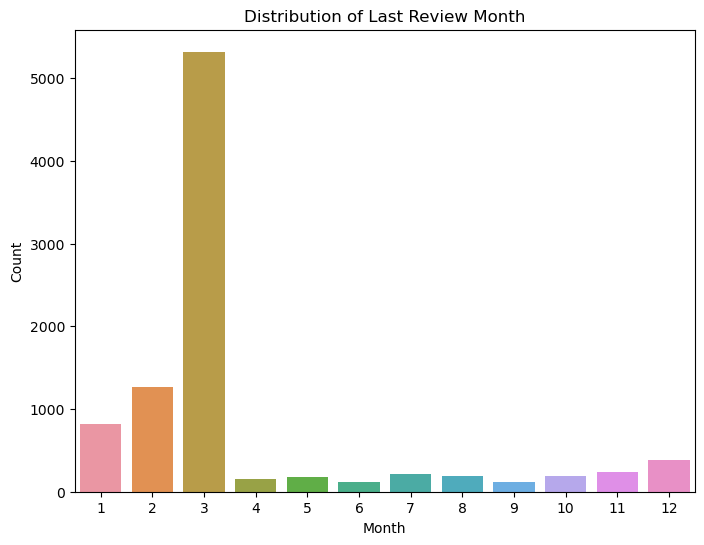

In [14]:
plt.figure(figsize=(8, 6))
sns.countplot(data=listings_cleaned, x='last_review_month')
plt.title('Distribution of Last Review Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.show()

**The plot shows that March had the highest count of reviews compared to other months. This could be attributed to various factors, including seasonality, events or festivals happening in March, the influence of spring break, or a significant number of listings becoming available for bookings during that month. These factors likely contributed to increased tourism and occupancy rates, resulting in a higher number of bookings and subsequent reviews**. 

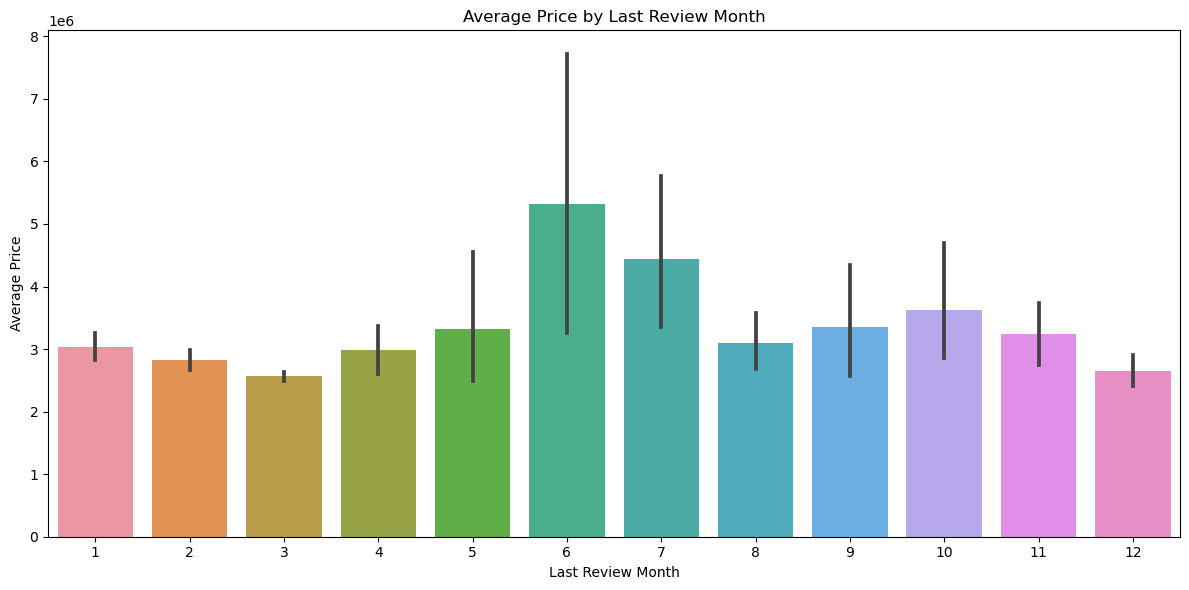

In [11]:
plt.figure(figsize=(12, 6))
sns.barplot(data=listings_cleaned, x='last_review_month', y='price')
plt.title('Average Price by Last Review Month')
plt.xlabel('Last Review Month')
plt.ylabel('Average Price')
plt.tight_layout()  
plt.savefig('../charts/average_price_by_last_review_month.png')

**The shorter black line for the month of March suggests that there is relatively less variability and higher confidence in the estimated average price for March compared to the other months**.

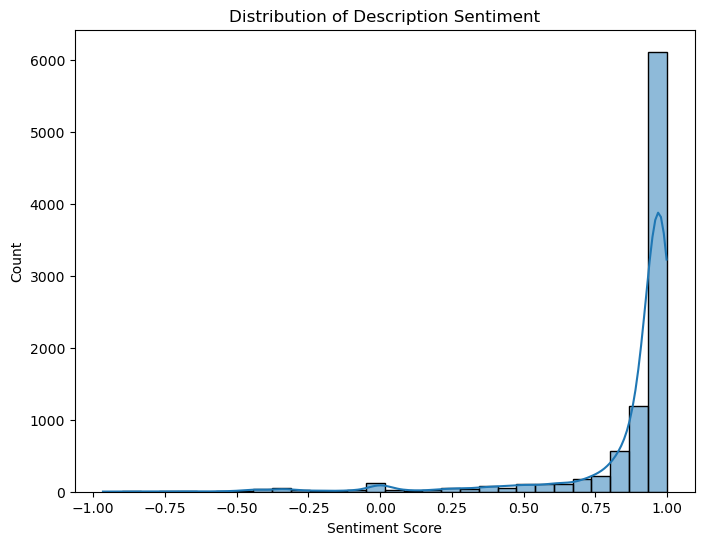

In [16]:
plt.figure(figsize=(8, 6))
sns.histplot(data=listings_cleaned, x='description_sentiment', bins=30, kde=True)
plt.title('Distribution of Description Sentiment')
plt.xlabel('Sentiment Score')
plt.ylabel('Count')
plt.show()


**The highest bar has a sentiment score of 1.00 with a count of about 6000 listings. This indicates that there are 6000 listings with a highly positive sentiment in their descriptions.
A sentiment score of 1.00 suggests that the descriptions of these listings have been analyzed as extremely positive by the sentiment analysis algorithm. It means that the text in these descriptions likely contains highly positive language, conveying favorable information about the listing, which can be appealing to potential guests**.

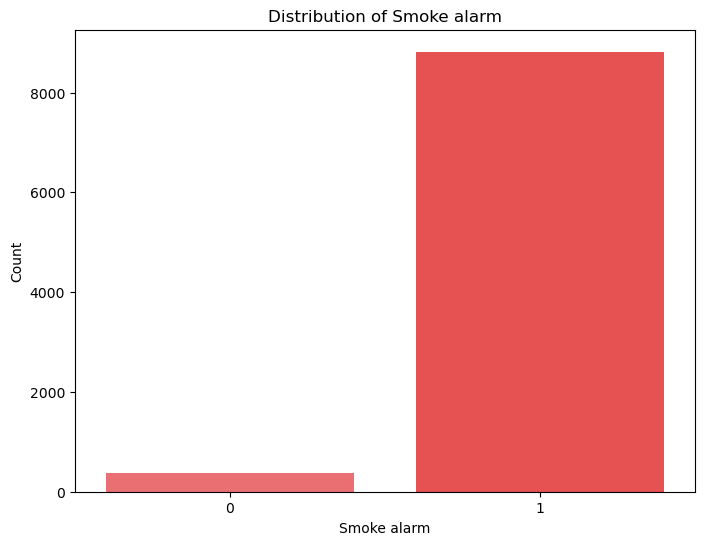

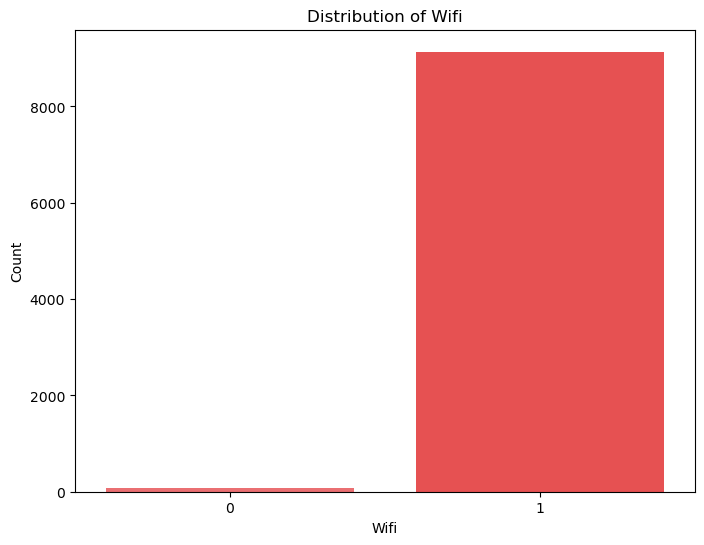

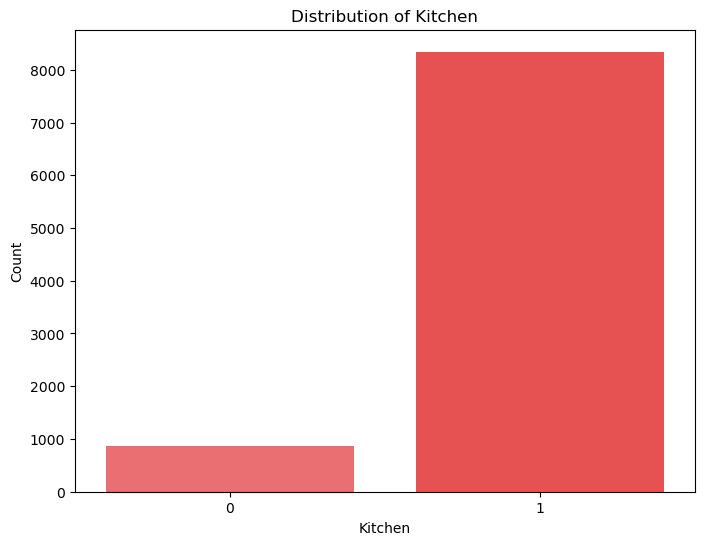

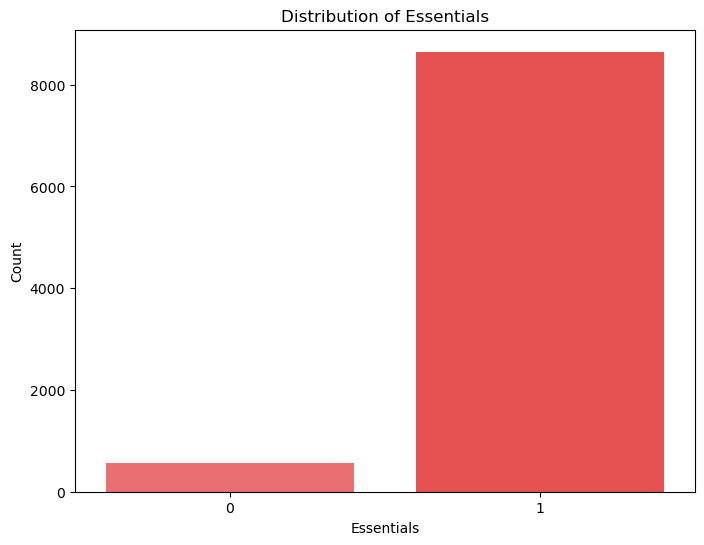

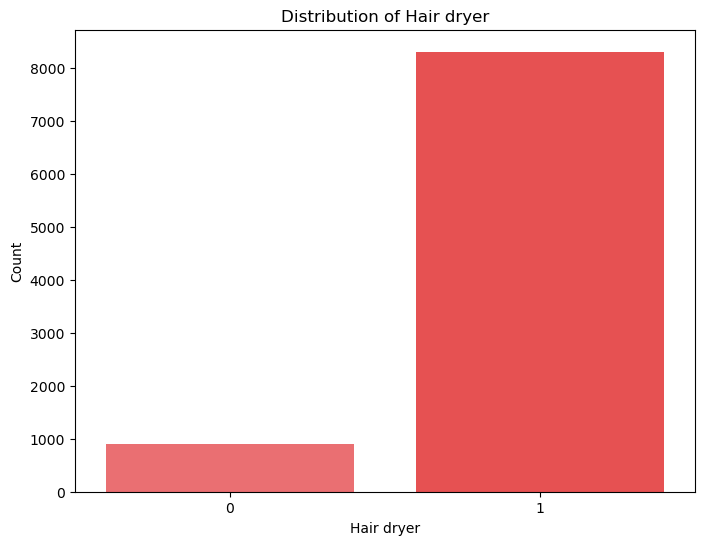

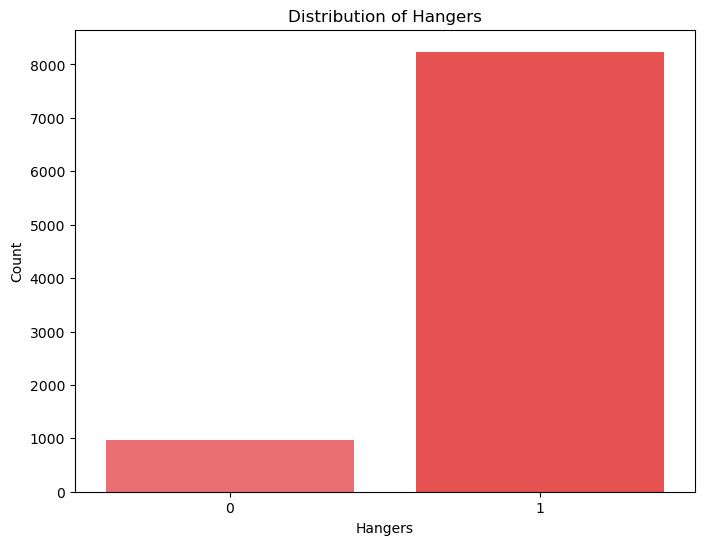

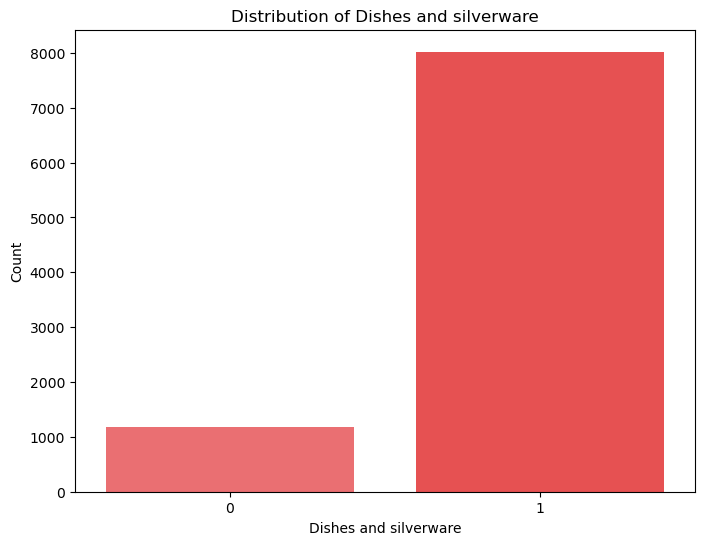

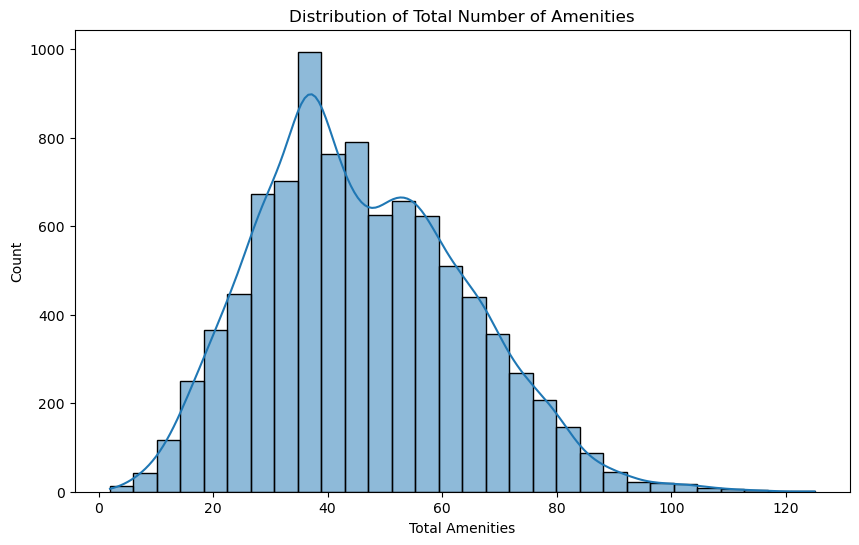

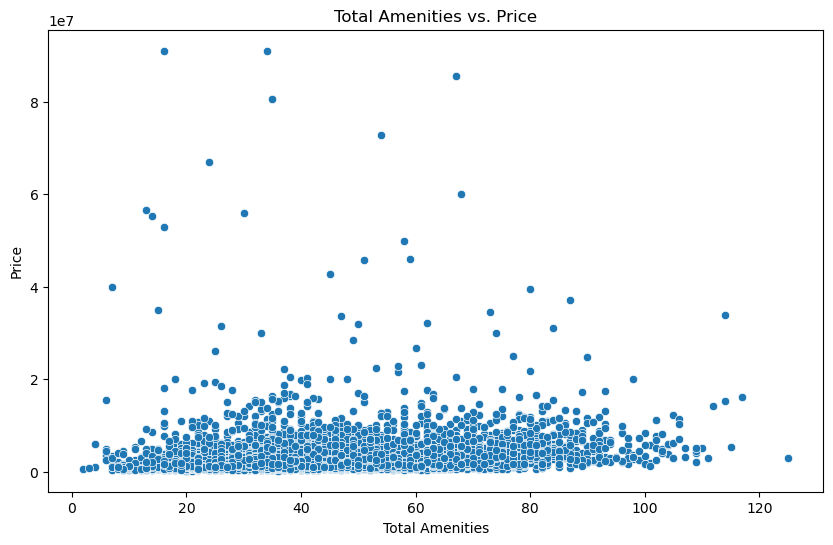

In [17]:
airbnb_colors = ["#FF5A5F", "#FF3839", "#484848", "#767676"]

# Distribution of specific amenities
amenities_to_explore = ['Smoke alarm', 'Wifi', 'Kitchen', 'Essentials', 'Hair dryer', 'Hangers', 'Dishes and silverware']

for amenity in amenities_to_explore:
    plt.figure(figsize=(8, 6))
    sns.countplot(data=listings_cleaned, x=amenity, palette=airbnb_colors)
    plt.title(f'Distribution of {amenity}')
    plt.xlabel(amenity)
    plt.ylabel('Count')
    plt.show()

# Distribution of total number of amenities
plt.figure(figsize=(10, 6))
sns.histplot(data=listings_cleaned, x='total_amenities', bins=30, kde=True, palette=airbnb_colors)
plt.title('Distribution of Total Number of Amenities')
plt.xlabel('Total Amenities')
plt.ylabel('Count')
plt.show()

# Relationship between total number of amenities and price
plt.figure(figsize=(10, 6))
sns.scatterplot(data=listings_cleaned, x='total_amenities', y='price', palette=airbnb_colors)
plt.title('Total Amenities vs. Price')
plt.xlabel('Total Amenities')
plt.ylabel('Price')
plt.show()


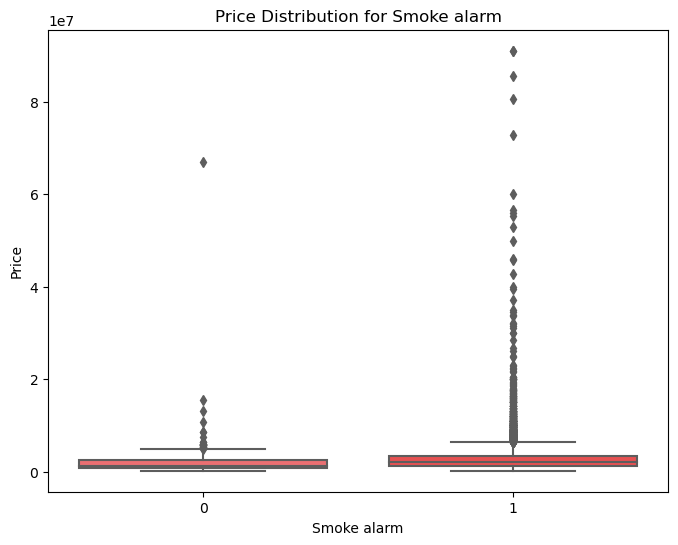

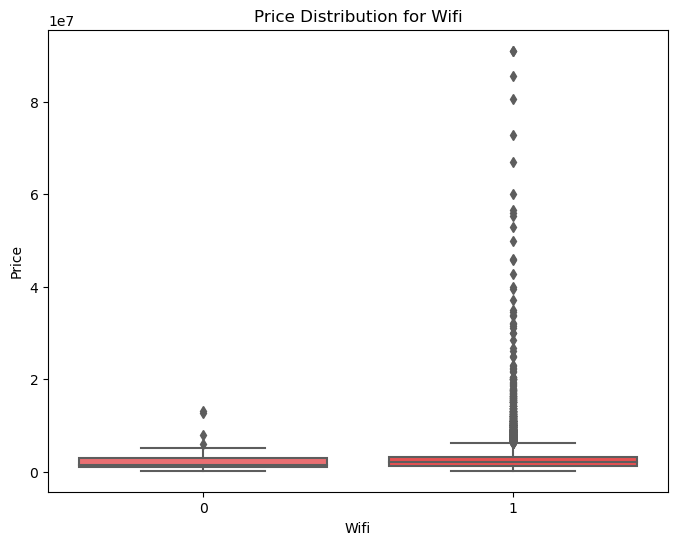

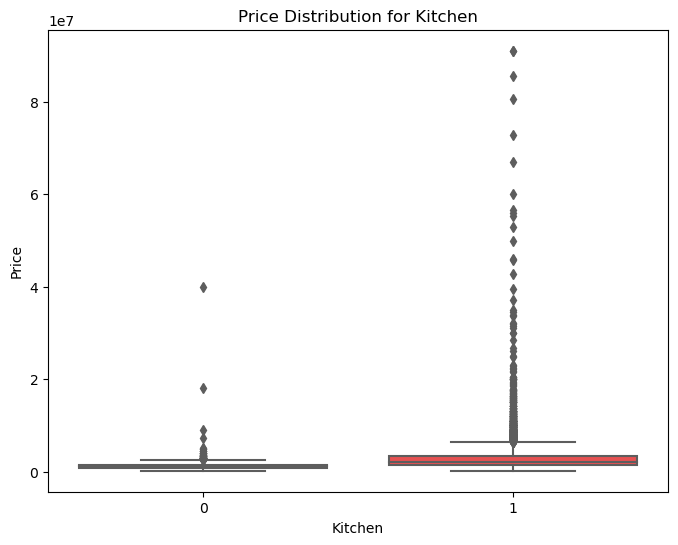

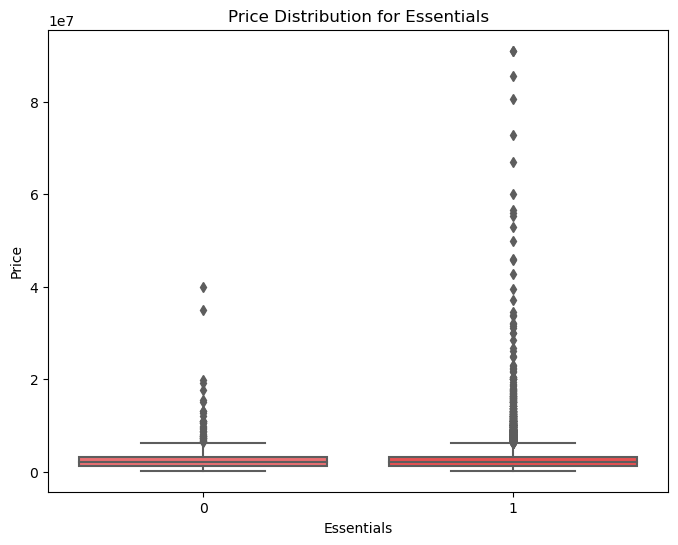

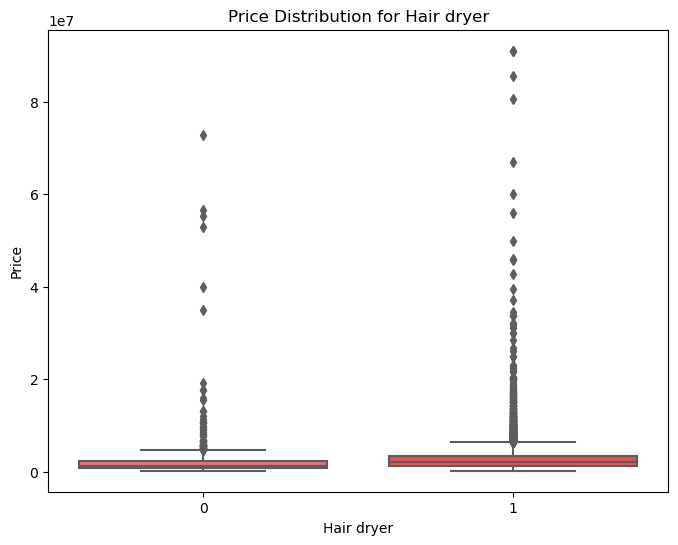

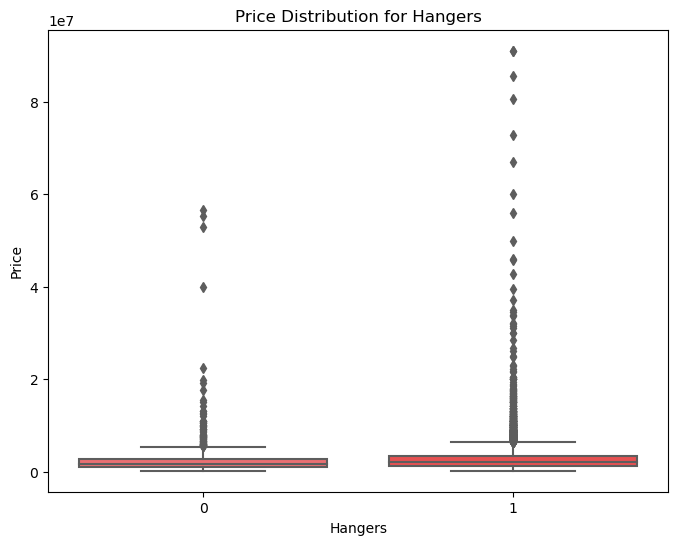

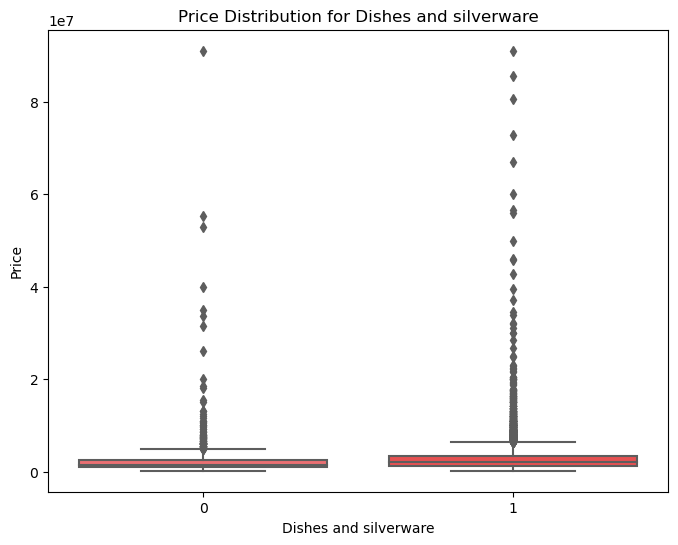

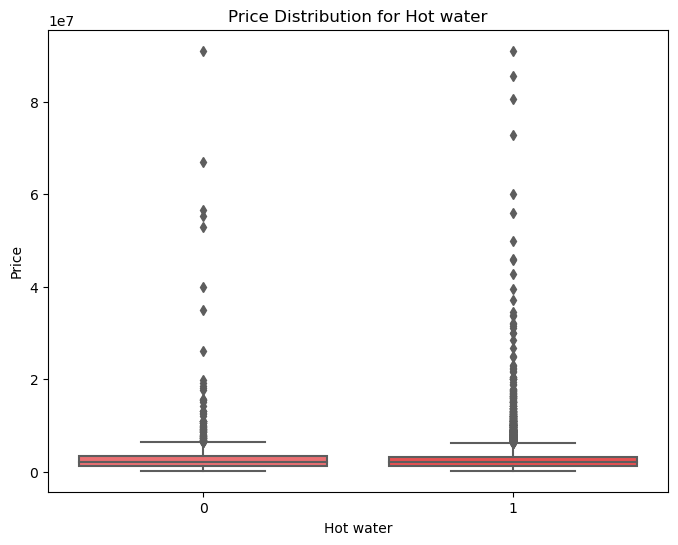

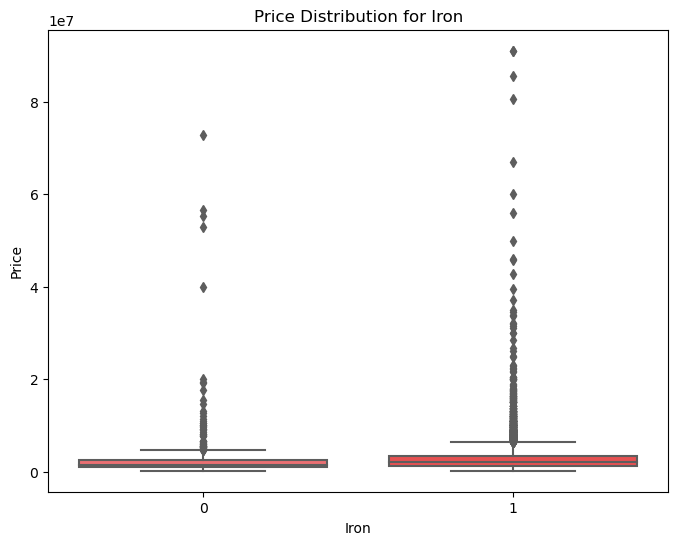

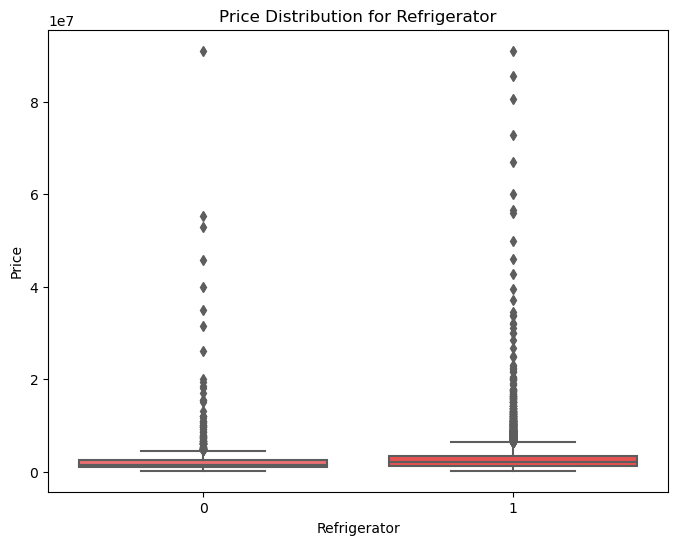

In [18]:
airbnb_colors = ["#FF5A5F", "#FF3839", "#484848", "#767676"]

for amenity in amenities_to_extract:
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=listings_cleaned, x=amenity, y='price', palette=airbnb_colors)
    plt.title(f'Price Distribution for {amenity}')
    plt.xlabel(amenity)
    plt.ylabel('Price')
    plt.show()


**The "Kitchen","Smoke alarm" and "Wifi" amenities in the dataset exhibit more outliers associated with listings that have these amenities compared to listings that don't have them, it suggests that the presence of these amenities plays a significant role in the variability of the data. For example, the availability and quality of a kitchen can vary among listings. Listings with well-equipped kitchens, modern appliances, and ample space may command higher prices compared to listings with basic or limited kitchen facilities**

In [19]:
# Scale numeric features
numeric_features = listings_cleaned.select_dtypes(include='number')
scaler = StandardScaler()
scaled_features = scaler.fit_transform(numeric_features)

# Define categorical features
categorical_features = listings_cleaned[['room_type', 'property_type']]

categorical_features = listings_cleaned[['room_type', 'property_type']]
encoder = OneHotEncoder()
encoded_features = encoder.fit_transform(categorical_features)

# Convert scaled features to DataFrame
scaled_df = pd.DataFrame(scaled_features, columns=numeric_features.columns)


# Encode categorical features
encoded_features = encoder.transform(categorical_features)
encoded_columns = encoder.get_feature_names_out(categorical_features.columns)


encoded_df = pd.DataFrame(encoded_features.toarray(), columns=encoded_columns)

# Combine scaled and encoded features
combined_df = pd.concat([scaled_df, encoded_df], axis=1)


# Save the combined DataFrame as CSV
combined_df.to_csv('../data/scaled_encoded_data.csv', index=False)